# Load Data

In [0]:
#@title ## Load CIFAR10 Data
#@markdown ### Train data: 50000 samples
#@markdown * Input shape: (32, 32, 3)
#@markdown * Label shape: (10)
#@markdown ### Train data: 10000 samples
#@markdown * Input shape: (32, 32, 3)
#@markdown * Label shape: (10)

from keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = np.squeeze(np.eye(10)[y_train] ,axis=1)
y_test = np.squeeze(np.eye(10)[y_test] ,axis=1)

# Build Model

In [0]:
#@title ## 1. Define Layer
#@markdown * ### PlaceHolder (shape, name=None)
#@markdown * ### Conv2D (input_layer, input_channel, output_channel, name='conv2d')
#@markdown * ### BatchNormalization (input_layer, name='batch_normalization')
#@markdown * ### Activation (input_layer, name='activation')
#@markdown * ### Add (input_layer1, input_layer2, name='add')
#@markdown * ### MaxPool (input_layer, name='max_pool')
#@markdown * ### AvgPool (input_layer, name='avg_pool')
#@markdown * ### Flatten (input_layer, name='flatten')
#@markdown * ### Dense (input_layer, units, name='dense')
#@markdown * ### Softmax (input_layer, name='softmax')
#@markdown * ### LayerSummary (layer)

import tensorflow as tf

def PlaceHolder(shape, name=None):
    return tf.placeholder(tf.float32, shape=[None] + shape, name=name)

def Conv2D(input_layer, input_channel, output_channel, name='conv2d'):
    conv2d_filter = tf.Variable(tf.random.normal([3, 3, input_channel, output_channel], stddev=0.01))
    return tf.nn.conv2d(input_layer, filter=conv2d_filter, strides=[1, 1, 1, 1], padding='SAME', name=name)

def BatchNormalization(input_layer, name='batch_normalization'):
    return tf.layers.batch_normalization(input_layer, center=True, scale=True, training=True, name=name)

def Activation(input_layer, name='activation'):
    return tf.nn.relu(input_layer, name=name)

def Add(input_layer1, input_layer2, name='add'):
    return tf.add(input_layer1, input_layer2, name=name)

def MaxPool(input_layer, name='max_pool'):
    return tf.nn.max_pool(input_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

def AvgPool(input_layer, name='avg_pool'):
    return tf.nn.avg_pool(input_layer, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME', name=name)

def Flatten(input_layer, name='flatten'):
    return tf.layers.flatten(input_layer, name=name)

def Dense(input_layer, units, name='dense'):
    return tf.layers.dense(input_layer, units=units, name=name)

def Softmax(input_layer, name='softmax'):
    return tf.nn.softmax(input_layer, name=name)

def LayerSummary(layers):
    for layer in layers:
        print("%-25s %-20s" % (layer.name.split(':')[0].split('/')[0], layer.shape))

In [0]:
#@title ## 2. Define CNN Block
#@markdown 1. ### InputLayer → Conv2D_1
#@markdown 2. ### Conv2D_1 → BatchNormalization_1
#@markdown 3. ### BatchNormalization_1 → Activation_1
#@markdown 4. ### Activation_1 → Conv2D_2
#@markdown 5. ### Conv2D_2 → BatchNormalization_2
#@markdown 6. ### BatchNormalization_2 → Activation_2
#@markdown 7. ### Activation_2 → Conv2D_3
#@markdown 8. ### Conv2D_3 → BatchNormalization_3
#@markdown 9. ### Activation_1 + BatchNormalization_3 → Add
#@markdown 10. ### Add → Activation_3 = OutputLayer


def CNNBlock(input_layer, input_channel, output_channel, block_index=0):
    b1x1 = block_index
    b1x3 = block_index * 3
    
    x1 = Conv2D(input_layer, input_channel, output_channel, name='conv2d_'+str(b1x3+1))
    x2 = BatchNormalization(x1, name='batch_normalization_'+str(b1x3+1))
    x3 = Activation(x2, name='activation_'+str(b1x3+1))

    x4 = Conv2D(x3, output_channel, output_channel, name='conv2d_'+str(b1x3+2))
    x5 = BatchNormalization(x4, name='batch_normalization_'+str(b1x3+2))
    x6 = Activation(x5, name='activation_'+str(b1x3+2))

    x7 = Conv2D(x6, output_channel, output_channel, name='conv2d_'+str(b1x3+3))
    x8 = BatchNormalization(x7, name='batch_normalization_'+str(b1x3+3))
    x9 = Add(x3, x8, name='add_'+str(b1x1+1))
    x10 = Activation(x9, name='activation_'+str(b1x3+3))
    
    LayerSummary([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10])
    return x10

In [0]:
#@title ## 3. Define Model
#@markdown 1. ### Input → CNNBlock_1
#@markdown 2. ### CNNBlock_1 → MaxPool_1
#@markdown 3. ### MaxPool_1 → CNNBlock_2
#@markdown 4. ### CNNBlock_2 → MaxPool_2
#@markdown 5. ### MaxPool_2 → CNNBlock_3
#@markdown 6. ### CNNBlock_3 → Flatten
#@markdown 7. ### Flatten → Dense
#@markdown 8. ### Dense → Softmax = Output

tf.reset_default_graph()

input_1 = PlaceHolder([32, 32, 3], name='input_1')
LayerSummary([input_1])
print()

cnn_output_1 = CNNBlock(input_1, input_channel=3, output_channel=16, block_index=0)
max_pool_1 = MaxPool(cnn_output_1, name='max_pool_1')
LayerSummary([max_pool_1])
print()

cnn_output_2 = CNNBlock(max_pool_1, input_channel=16, output_channel=32, block_index=1)
max_pool_2 = MaxPool(cnn_output_2, name='max_pool_2')
LayerSummary([max_pool_2])
print()

cnn_output_3 = CNNBlock(max_pool_2, input_channel=32, output_channel=64, block_index=2)
avg_pool_1 = AvgPool(cnn_output_3, name='avg_pool_1')
LayerSummary([avg_pool_1])
print()

flatten_1 = Flatten(avg_pool_1, name='flatten_1')
dense_1 = Dense(flatten_1, units=10, name='dense_1')
output_1 = Softmax(dense_1, name='softmax_1')
LayerSummary([flatten_1, dense_1, output_1])

label = PlaceHolder([10], name='label')

input_1                   (?, 32, 32, 3)      

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
conv2d_1                  (?, 32, 32, 16)     
batch_normalization_1     (?, 32, 32, 16)     
activation_1              (?, 32, 32, 16)     
conv2d_2                  (?, 32, 32, 16)     
batch_normalization_2     (?, 32, 32, 16)     
activation_2              (?, 32, 32, 16)     
conv2d_3                  (?, 32, 32, 16)     
batch_normalization_3     (?, 32, 32, 16)     
add_1                     (?, 32, 32, 16)     
activation_3              (?, 32, 32, 16)     
max_pool_1                (?, 16, 16, 16)     

conv2d_4                  (?, 16, 16, 32)     
batch_normalization_4     (?, 16, 16, 32)     
activation_4              (?, 16, 16, 32)     
conv2d_5                  (?, 16, 16, 32)     
batch_normalization_5     (?, 16, 16, 32)     
activation_5              (?, 16, 16, 32)     
conv2d_

In [0]:
#@title ## 4. Define Cost, Optimizer, and Accuracy
#@markdown * ### Cost: Categorical Crossentropy
#@markdown * ### Optimizer: Adam (Learning rate = 0.001)
#@markdown * ### Accuracy

cost = tf.reduce_mean(-tf.reduce_sum(label * tf.log(tf.clip_by_value(output_1, 1e-10, 1.0)), [1]))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
is_correct = tf.equal(tf.argmax(label, 1), tf.argmax(output_1, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# Train Model

In [0]:
#@title ## 1. Train Model

Epoch = 30 #@param {type:"integer"}
Batch_Size = 100 #@param {type:"integer"}

train_histroy = {'train_cost': [], 'train_accuracy': [], 'test_accuracy': []}

print('Training start...')
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    total_batch = x_train.shape[0] // Batch_Size

    for epoch in range(Epoch):
        total_cost_train = 0

        for i in range(total_batch):
            batch_x_train = x_train[i * Batch_Size : (i+1) * Batch_Size]
            batch_y_train = y_train[i * Batch_Size : (i+1) * Batch_Size]
            
            feed_dict = {input_1: batch_x_train, label: batch_y_train}
            _, cost_train, accuracy_train = session.run([optimizer, cost, accuracy], feed_dict=feed_dict)
            total_cost_train += cost_train
            
        accuracy_test = session.run(accuracy, feed_dict={input_1: x_test, label: y_test})
        
        train_histroy['train_cost'].append(total_cost_train / total_batch);
        train_histroy['train_accuracy'].append(accuracy_train);
        train_histroy['test_accuracy'].append(accuracy_test);
            
        print('Epoch: {0:04d} - '.format(epoch + 1), end='')
        print('Avg. cost: {0:.3f}, '.format(train_histroy['train_cost'][-1]), end='')
        print('Train Acc.: {0:.4f}, '.format(train_histroy['train_accuracy'][-1]), end='')
        print('Test Acc.: {0:.4f}'.format(train_histroy['test_accuracy'][-1]))

    print('Training done.')

Training start...
Epoch: 0001 - Avg. cost: 1.297, Train Acc.: 0.6100, Test Acc.: 0.6492
Epoch: 0002 - Avg. cost: 0.904, Train Acc.: 0.6600, Test Acc.: 0.7162
Epoch: 0003 - Avg. cost: 0.741, Train Acc.: 0.7000, Test Acc.: 0.7460
Epoch: 0004 - Avg. cost: 0.644, Train Acc.: 0.7200, Test Acc.: 0.7650
Epoch: 0005 - Avg. cost: 0.570, Train Acc.: 0.7500, Test Acc.: 0.7828
Epoch: 0006 - Avg. cost: 0.513, Train Acc.: 0.7700, Test Acc.: 0.7885
Epoch: 0007 - Avg. cost: 0.468, Train Acc.: 0.8100, Test Acc.: 0.7909
Epoch: 0008 - Avg. cost: 0.429, Train Acc.: 0.8100, Test Acc.: 0.7955
Epoch: 0009 - Avg. cost: 0.392, Train Acc.: 0.8400, Test Acc.: 0.7939
Epoch: 0010 - Avg. cost: 0.358, Train Acc.: 0.8500, Test Acc.: 0.7936
Epoch: 0011 - Avg. cost: 0.329, Train Acc.: 0.8800, Test Acc.: 0.7915
Epoch: 0012 - Avg. cost: 0.303, Train Acc.: 0.8800, Test Acc.: 0.7941
Epoch: 0013 - Avg. cost: 0.273, Train Acc.: 0.8900, Test Acc.: 0.7939
Epoch: 0014 - Avg. cost: 0.246, Train Acc.: 0.8800, Test Acc.: 0.7956
Ep

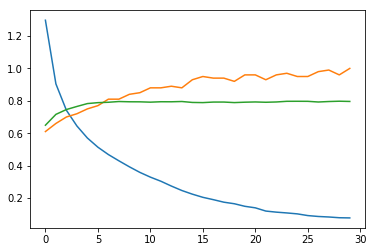

In [0]:
#@title ## 2. Plot Train Result
import matplotlib.pyplot as plt

plt.plot(train_histroy['train_cost'])
plt.plot(train_histroy['train_accuracy'])
plt.plot(train_histroy['test_accuracy'])
plt.show()